In [2]:
import os
import sys
sys.path.append(os.path.normpath(os.path.join('../')))

import os
import clip
import torch
from pinecone import Pinecone
from PIL import Image
from IPython.display import display
from dotenv import dotenv_values
from model import load_dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
_, preprocess = clip.load("ViT-B/32", device=device)

os.environ['EXTRACT_DIR'] = "/tmp/GLAMI-1M/"
load_dataset.download_dataset(dataset_url="https://huggingface.co/datasets/glami/glami-1m/resolve/main/GLAMI-1M-dataset--test-only.zip")

config = dotenv_values('../database/.env')
api_key = config['API_KEY']


c:\Users\PC\anaconda3\envs\ai\lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Dataset sub directory already exists in the extract dir. Delete it to re-download.


In [3]:
# load pretrained model
model = torch.load('../model/model_storage/pretrained_clip.pt')

In [4]:
df = load_dataset.get_dataframe('test')[['category_name', 'image_file']]
df = df.drop_duplicates(subset=['image_file'])[['category_name', 'image_file']].reset_index(drop=True)

In [5]:
pc = Pinecone(api_key=api_key)
index = pc.Index("demo-fashion-retrieval")

In [9]:
def image2embs(image_query):
    image = preprocess(Image.open(image_query).convert('RGB')).unsqueeze(0).to(device)
    embs = model.encode_image(image)
    return embs.detach().cpu().numpy()[0].tolist()

def text2emb(text_query):
    text_token = clip.tokenize(text_query)
    text_emb = model.encode_text(text_token.to(device))
    return text_emb.detach().cpu().numpy()[0].tolist()

def search(input_emb, top_k):
    matching = index.query(vector=input_emb, top_k=top_k, include_values=True)['matches']
    match_ids = [match_id['id'] for match_id in matching]
    return match_ids[1: ]

def display_top_similarity(query):
    try:
        emb = image2embs(query)
    except:
        emb = text2emb(query)
    match_ids = search(emb, 10)
    for i in map(int, match_ids):
        display(Image.open(df.image_file[i]).convert('RGB'))

# Image query

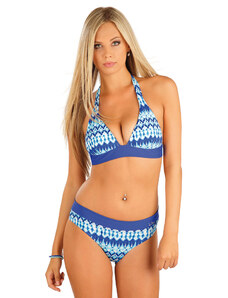

In [7]:
# image from database
Image.open(df.image_file[6437])

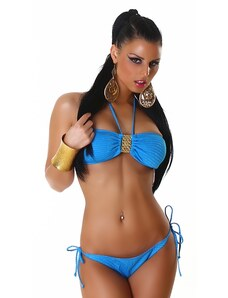

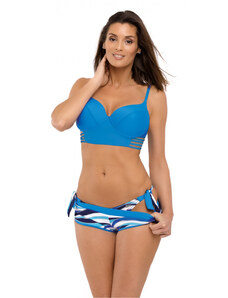

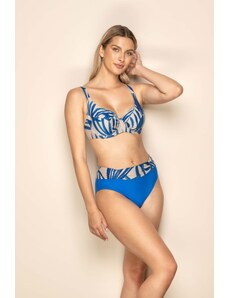

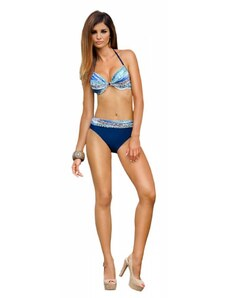

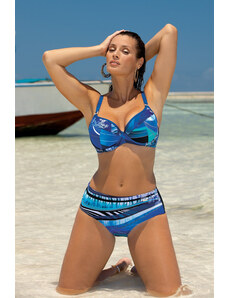

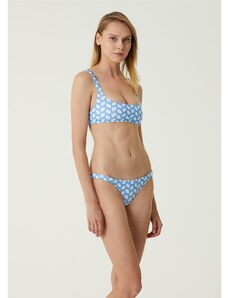

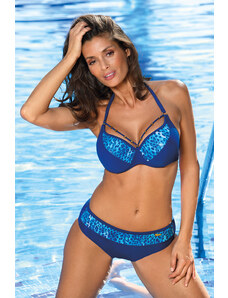

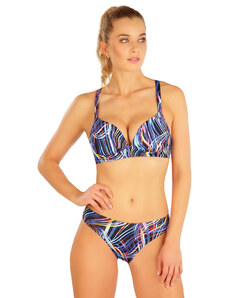

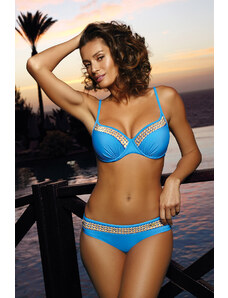

: 

In [10]:
images_query = df.image_file[6437]
display_top_similarity(images_query)